In [65]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import dask

In [2]:
from estimator import RFClassifier, relu, bp_weights_dft, bp_weights
from data_fns import pure_sine_dft

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:36033 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [4]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [53]:
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 8, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

signal frequency=80 Hz


In [66]:
# visualize the Fourier coefficients
pos = X_train[y_train==1]
neg = X_train[y_train != 1]

B = scipy.linalg.dft(X.shape[1])
dft_positive = pos @ B
dft_negative = neg @ B

In [54]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [55]:
%%time
# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k - 3, highcut=k + 3)
h = relu

weights = [('bandpass_dft', f_gaus), ('white noise', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

CPU times: user 5.56 s, sys: 2.28 s, total: 7.84 s
Wall time: 25.3 s


In [56]:
mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

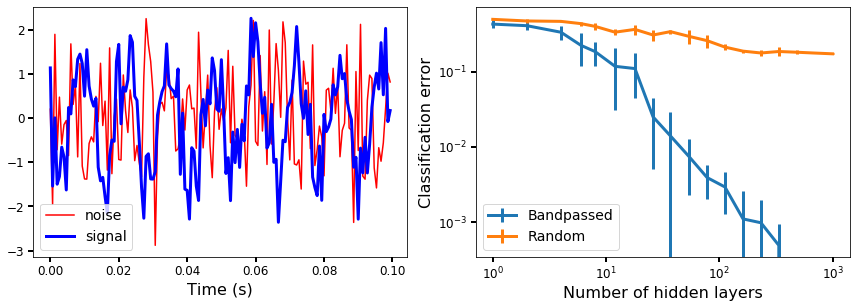

In [129]:
t = np.arange(N) / fs
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(221)
plt.plot(t, X_train[y_train==-1][0], c='r', label='noise')
plt.plot(t, X_train[y_train==1][0], c='b', lw=3, label='signal')
plt.xlabel('Time (s)', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc='lower left', fontsize=14)

# ax = fig.add_subplot(222)
# ax.set_title('DFT Coefficients at the signal frequency')
# ax.scatter(dft_positive[:, k].real, dft_positive[:, k].imag, c='b', label='signal')
# ax.scatter(dft_negative[:, k].real, dft_negative[:, k].imag, c='r', label='noise')
# plt.xlabel('Real')
# plt.ylabel('Imaginary')


ax = fig.add_subplot(222)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='Bandpassed',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='Random',  
            markersize=4, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Number of hidden layers', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'lower left', fontsize=14)

plt.tight_layout()
plt.savefig('figures/deepmath/abstract.png')

In [117]:
pwd

'/home/bpandey/kernels'